# N-gram Models

To do:
 - switch to model from ngram extractor (rather than CountVectorizer)
 - implement class NgramModel with method: sampling

In [712]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer as CV
import numpy as np
from matplotlib import pyplot as plt

TOKEN_PATTERN = r"(?u)\b[a-zA-Z]+\b|\</?s\>"
SENT_START_TOKEN = '<s>'
SENT_END_TOKEN = '</s>'

## Large Movie Review Dataset
From https://ai.stanford.edu/~amaas/data/sentiment/: This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text and already processed bag of words formats are provided. See the README file contained in the release for more details.

(direct link https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz)

Here we use this dataset arranged in a .csv file as an be found at https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download


Read dataset file. Each row is a review. 

In [1088]:
df = pd.read_csv("/Users/kipnisal/Downloads/IMDB Dataset.csv")
print(df.describe())
print(df.head())

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     <s> Loved today's show!!! It was a variety and...  positive
freq                                                    5     25000
                                              review sentiment
0  <s> One of the other reviewers has mentioned t...  positive
1  <s> A wonderful little production </s> <s>  <b...  positive
2  <s> I thought this was a wonderful way to spen...  positive
3  <s> Basically there's a family where a little ...  negative
4  <s> Petter Mattei's "Love in the Time of Money...  positive


Add sentence start and ending symbols

In [ ]:
import re

def break_sentence(text: str, sep=r'\.|\n'):
    """
    Add SENT_START_TOKEN and SENT_END_TOKEN at the beginning and
    ending of every sentence. 
    
    Args:
        :text: is a text input
        :sep: explains how to identify sentnce ending (regular expression)
    """
    sentences = re.split(sep, text)
    sent_break = f' {SENT_END_TOKEN} {SENT_START_TOKEN} '
    return SENT_START_TOKEN + ' ' + sent_break.join(sentences) + ' ' + SENT_END_TOKEN

df['review'] = df.review.apply(break_sentence)

## Unigram Model

Use CountVectorizer from sklearn package. This module is used for counting the number of occurances of 
all ngrams in a list of strings. The range (n,n+k) means count n-grams, (n+1)-grams,...,(n+k) grams. To 
get only k-grams, we use 'ngram_range=(n,n)'. We change the token pattern becsasue by the standard CV pattern
"r'\b\w\w+\b'" requires at least two letters in every word and ignores the sepical symbols $<s>$ and $</s>$

Below we count unigrams, hence we take $n=1$ 

We first list all words. We remove numbers and white spaces and lower case the text.

In [723]:
tokens = []
for sent in df['review']:
    tokens += re.findall(TOKEN_PATTERN, sent.lower())

The next line do the actualy counting. It returns a (sparse) matrix indicating the number of occurances of each
ngram (rows) in each document (columns). 

In [726]:
df_counts = pd.DataFrame(pd.DataFrame(tokens).value_counts())\
                .rename(columns = {0 : 'count'})

df_counts.loc[:, 'freq'] = df_counts['count'] / df_counts['count'].sum()
model_1gram = df_counts

In [727]:
model_1gram.head(15)

,count,freq
0,,
</s>,700520,0.052692
<s>,700520,0.052692
the,667993,0.050246
and,324441,0.024404
a,322970,0.024294
of,289410,0.021769
to,268124,0.020168
is,211082,0.015877
br,201951,0.015191


We see that the two special symbols are also most frequent. These are meaningless in a unigram model hence we remove them. 

In [735]:
model_1gram = model_1gram.drop(['</s>', '<s>'])
model_1gram['freq'] = model_1gram['count'] / model_1gram['count'].sum()

Illustrating "Zipf law" $f_i \propto 1/i$ for uniframs. Zipf "law" is a phenomena discovered by American linguist George Kingsley Zipf
https://en.wikipedia.org/wiki/George_Kingsley_Zipf

The Zipf phenomena only occurs in the most frequent words, after which the tail become thiner than $1/i$. 

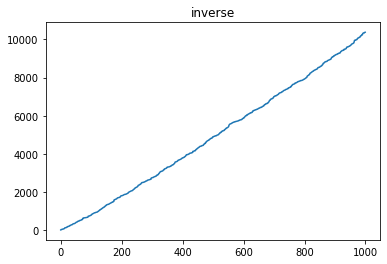

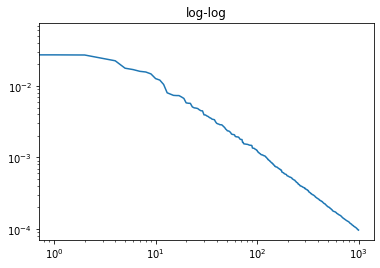

In [736]:
plt.title("inverse")
plt.plot(1 / model_1gram.freq.values[:1000])
plt.show()

plt.title("log-log")
plt.loglog(model_1gram.freq.values[:1000])
plt.show()

The entire procedure is summarized as follows

In [1246]:
from nltk import ngrams

def ng_tokenize(text, ng):
    """
    extract ngram and add sepcial symbols
    """
    tokens = re.findall(TOKEN_PATTERN, text.lower())
    ngz = ngrams(tokens, ng,
                   pad_left=True, pad_right=True,
                   left_pad_symbol=SENT_START_TOKEN, right_pad_symbol=SENT_END_TOKEN)
    return list(ngz)


def build_ngram_model(text, ng):
    print("Cleaning text...")
    text = re.sub(r"<br ?/>","", text)  # remove html tags <br /> and <br/>
    print("Extracting tokens...")
    tokens = ng_tokenize(text, ng)
    print("Removing unwanted tokens...")
    tokens = [t for t in tokens if not (('<s>' in t[1:]) or ('</s>' in t[:-1]) or (t == ("<s>", "</s>")))]
    print("Counting tokens...")
    df_ng = pd.DataFrame(pd.DataFrame(tokens).value_counts()).rename(columns = {0 : 'count'})
    print("Computing frequencies...")
    df_ng.loc[:, 'freq'] = df_ng['count'] / df_ng['count'].sum()  # compute frequencies
    return df_ng

## Bigrams

In [1247]:
model_2gram = build_ngram_model(" ".join(df.review), 2)

Cleaning text...
Extracting tokens...
Removing unwanted tokens...
Counting tokens...
Computing frequencies...


In [1250]:
k = 15
print(f" {k} most frequenct tokens:")
print(model_2gram.head(k))

 15 most frequenct tokens:
            count      freq
0    1                     
of   the    77220  0.006284
<s>  the    72914  0.005933
     i      60028  0.004885
in   the    50258  0.004090
<s>  it     33949  0.002763
it   s      33748  0.002746
this movie  31481  0.002562
<s>  this   27899  0.002270
the  film   26920  0.002191
and  the    26672  0.002170
is   a      26060  0.002121
the  movie  23955  0.001949
to   the    23616  0.001922
     be     23481  0.001911
this film   21813  0.001775


Bigrams also obey the Zipf law:

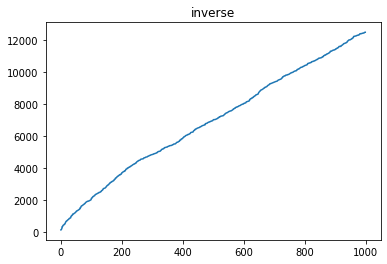

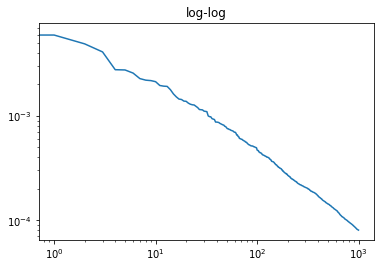

In [1143]:
plt.title("inverse")
plt.plot(1 / df2g.freq.values[:1000])
plt.show()

plt.title("log-log")
plt.loglog(df2g.freq.values[:1000])
plt.show()

## Trigrams

In [1144]:
model_3gram = build_ngram_model(" ".join(df.review), 3)

Cleaning text...
Extracting ngrams...
Removing unwanted ngrams...
Counting ngrams...
Computing frequencies...


In [1255]:
k = 15
print(f"{k} most frequent 3grams:")
print(model_3gram.head(k))

15 most frequent 3grams:
                  count      freq
0    1     2                     
<s>  it    s      11082  0.000948
one  of    the     9819  0.000840
<s>  this  is      8664  0.000741
     it    is      5913  0.000506
     if    you     5818  0.000498
     this  movie   5757  0.000493
i    don   t       5415  0.000463
this movie is      5262  0.000450
of   the   film    5169  0.000442
this is    a       4810  0.000412
it   s     a       4700  0.000402
a    lot   of      4694  0.000402
this movie </s>    4468  0.000382
of   the   movie   4325  0.000370
<s>  the   film    4324  0.000370


# Sentence probability


In [1146]:
class State(object):
    """
    simple class to handle sequential state progression
    
    Args:
        past, present, future  are lists
        
    Methods:
        State::step   update one step in time, so that the present 
        is appended to the past and the present gets the next value from the future
    """
    def __init__(self, past, present, future):
        self.past = past
        self.present = present
        self.future = future
        
    def step(self):
        self.past += self.present
        if len(self.future) > 0:
            self.present = [self.future.pop(0)]
        else:
            self.present = []
            self.future = []


In [1147]:

def token_probability(token : str, model):
    """
    probability of a token under the model
    
    Note: gives the marginal if number of ngrams in token is smaller
    than the size of the model
    
    If token = "" then return 1
    
    """
    if len(token) == 0:
        return 1
    token_idx = tuple(token)
    return model.loc[token_idx].freq.sum()


def conditional_probability(token_a : str, token_b : str, model):
    """
    Probability of :token_a: given :token_b: under model :model:
    """
    
    pr_b = token_probability(token_b, model)
    pr_ab = token_probability(token_b + token_a, model)
    return pr_ab / pr_b
    
    
def sentence_probability(sent: str, model, verbose=False):
    """
    Probability of a sentence under an n-gram languge model
    
    Args:
        :sent:    the sentence 
        :model:   the model
        :verbose: flag whther to print computing process
    """
    
    ng = len(model.index[0])  # identify model order

    sent_atoms = sent.split()  
    first_ngram =sent_atoms[:ng] 

    state = State(past=[], present=first_ngram, future=sent_atoms[ng:])

    # update state
    logprob = 0
    while len(state.present) > 0:
        pr_token = conditional_probability(state.present, state.past[-ng+1:], model)
        logprob += np.log(pr_token)
        if verbose:
            print("past:", state.past)
            print("present:", state.present)
            print("future:", state.future)
            print(f"P(present|past) = {pr_token}")
            print("------------------------------------")
        state.step()

    return np.exp(logprob)


In [1159]:
sentence_probability("<s> only one movie to read </s>", model_3gram)

5.421248159871611e-15

Make sure that conditional probability behaves as expected:

In [1263]:
test_tokens = ['<s>', 'on', 'of', 'there', 'movie']
for t in test_tokens:
    assert conditional_probability([t],[], model_2gram) == token_probability([t], model_2gram)

### Probability of a bigram:

In [1163]:
print(conditional_probability(['of'], ['one'], model_2gram)) #* token_probability('one', model_2gram))
print(sentence_probability("one of", model_2gram))
print(sentence_probability("<s> one of </s>", model_2gram))
print(sentence_probability("one of </s>", model_2gram))

0.30314453671736497
0.0013218255416502392
7.921010475950982e-07
1.0761849552581969e-05


Explain why the first two are identical and why the last two are different.

#### Probability of a longer sentence:

##### Bigram model:

In [1179]:
print(sentence_probability("<s> what a great movie it was </s>", model_2gram, verbose=True))

past: []
present: ['<s>', 'what']
future: ['a', 'great', 'movie', 'it', 'was', '</s>']
P(present|past) = 0.0004417748624488519
------------------------------------
past: ['<s>', 'what']
present: ['a']
future: ['great', 'movie', 'it', 'was', '</s>']
P(present|past) = 0.059117428003972204
------------------------------------
past: ['<s>', 'what', 'a']
present: ['great']
future: ['movie', 'it', 'was', '</s>']
P(present|past) = 0.01866883871027684
------------------------------------
past: ['<s>', 'what', 'a', 'great']
present: ['movie']
future: ['it', 'was', '</s>']
P(present|past) = 0.04405602117335686
------------------------------------
past: ['<s>', 'what', 'a', 'great', 'movie']
present: ['it']
future: ['was', '</s>']
P(present|past) = 0.01125831580144425
------------------------------------
past: ['<s>', 'what', 'a', 'great', 'movie', 'it']
present: ['was']
future: ['</s>']
P(present|past) = 0.08854251287991151
------------------------------------
past: ['<s>', 'what', 'a', 'great',

##### Trigram model

In [1180]:
print(sentence_probability("<s> what a great movie it was </s>", model_3gram, verbose=True))

past: []
present: ['<s>', 'what', 'a']
future: ['great', 'movie', 'it', 'was', '</s>']
P(present|past) = 7.015180851362348e-05
------------------------------------
past: ['<s>', 'what', 'a']
present: ['great']
future: ['movie', 'it', 'was', '</s>']
P(present|past) = 0.05984251968503937
------------------------------------
past: ['<s>', 'what', 'a', 'great']
present: ['movie']
future: ['it', 'was', '</s>']
P(present|past) = 0.0975447909754479
------------------------------------
past: ['<s>', 'what', 'a', 'great', 'movie']
present: ['it']
future: ['was', '</s>']
P(present|past) = 0.02377972465581978
------------------------------------
past: ['<s>', 'what', 'a', 'great', 'movie', 'it']
present: ['was']
future: ['</s>']
P(present|past) = 0.11818181818181817
------------------------------------
past: ['<s>', 'what', 'a', 'great', 'movie', 'it', 'was']
present: ['</s>']
future: []
P(present|past) = 0.019947910500769505
------------------------------------
2.295660835856814e-11


Trigram probability is higher for more "natural" sentences

In [1183]:
print(sentence_probability("one of the best action movies", model_3gram))

1.7686057752001027e-08


In [1184]:
print(sentence_probability("one of the best car movie", model_3gram))

3.0318956146287426e-09


The method breaks when we ask for unseen ngrams:

In [1171]:
try:
    print(sentence_probability("<s> only one movie to bake </s>", model_3gram))
except KeyError as e:
    print("Issue with trigram ", e)
    

Issue with trigram  ('movie', 'to', 'bake')


One solution is smoothing

In [1187]:
sent = "<s> a wonderful little production </s>"
print(f"2gram probability of '{sent}': p = ", sentence_probability(sent, model_2gram))
print(f"3gram probability of '{sent}': p = ", sentence_probability(sent, model_3gram))

2gram probability of '<s> a wonderful little production </s>': p =  8.746416808025598e-13
3gram probability of '<s> a wonderful little production </s>': p =  7.385032510793528e-10


In general, the 3-gram model suppose to give higher probabilities to more English looking sentences

Explain the last difference

### What kinds of knowledge we can get from a model?

In [1254]:
model = model_3gram
print("actor vs. actress")
print("=================")

for w in ['good', 'great', 'talented', 'poor']:
    print(w)
    p1 = conditional_probability(['actor'], [w.lower()], model)
    p2 = conditional_probability(['actress'], [w.lower()], model)
    print("\tactor: ", p1)
    print("\tactoress: ", p2)
    print("\tratio: ", p1/p2)


actor vs. actress
good
	actor:  0.006785661602006195
	actoress:  0.0033190736096769436
	ratio:  2.0444444444444443
great
	actor:  0.011454619835193736
	actoress:  0.004675355034772954
	ratio:  2.45
talented
	actor:  0.04562043795620438
	actoress:  0.03375912408759124
	ratio:  1.3513513513513513
poor
	actor:  0.001956400223588597
	actoress:  0.0005589714924538849
	ratio:  3.5


Gramer correction:

In [326]:
print(sentence_probability("one of the best action movies ever", df3g, df2g))
print(sentence_probability("one of the best action movie ever", df3g, df2g))

1.0445645846615367e-09
2.628834536554988e-10


The first option is more likely

In [327]:
print(sentence_probability("talking to her", df2g, df1g))
print(sentence_probability("talking at her", df2g, df1g))

1.1738447131142477e-07
6.065403352933208e-09


Movies are more likely to be watched than read:

In [1165]:
print(sentence_probability("<s> only one movie to read </s>", model_3gram))
print(sentence_probability("<s> only one movie to watch </s>", model_3gram))

5.421248159871611e-15
5.748805396404806e-12


In [1367]:
!pwd

/Users/kipnisal/Teaching/IT/notebooks


## Perplexity

In [1204]:
def sentence_probability_soft(sent: str, model, verbose=False):
    """
    Probability of a sentence under an n-gram languge model
    
    Args:
        :sent:    the sentence 
        :model:   the model
        :verbose: flag whther to print computing process
    """
    
    ng = len(model.index[0])  # identify model order

    sent_atoms = sent.split()  
    first_ngram =sent_atoms[:ng] 

    state = State(past=[], present=first_ngram, future=sent_atoms[ng:])

    # update state
    logprob = 0
    N = len(sent_atoms)
    while len(state.present) > 0:
        try:
            pr_token = conditional_probability(state.present, state.past[-ng+1:], model)
        except KeyError as e:
            print(f"Could not evaluate token {e}.")
            pr_token = 1
            N = N - 1
        logprob += np.log(pr_token)
        if verbose:
            print("past:", state.past)
            print("present:", state.present)
            print("future:", state.future)
            print(f"P(present|past) = {pr_token}")
            print("------------------------------------")
        state.step()

    return np.exp(logprob), N


In [1205]:
def perplexity(sentence, model):
    prob, N_valid = sentence_probability_soft(sentence, model)
    return -np.log(prob) / N_valid
        

In [1237]:
import re

def preprocess_sentence(text):
    n = ng
    text = re.sub(r"<br ?/>", "", text)  # remove the word '<br />' if it exists in the text
    return " ".join(re.findall(TOKEN_PATTERN, text)).lower()

In [413]:
def to_sentences(text):
    text = text.strip('<s> ').strip(' </s>')
    texts = text.split(' </s> <s> ')
    return [t.strip() for t in texts]

Perplexity of one sentence:

In [1269]:
sentences = ["<s> not as good as your average movie but still does the trick </s>",
             "<s> great do me but soon get out </s>"]

for sent in sentences:
    print("Sentence: ", sent)
    print(f"LPP of bigram model = {perplexity(sent, model_2gram)}")
    print(f"LPP of trigram model = {perplexity(sent, model_3gram)}")
    print()

Sentence:  <s> not as good as your average movie but still does the trick </s>
LPP of bigram model = 4.598590373748019
LPP of trigram model = 3.6343560644357678

Sentence:  <s> great do me but soon get out </s>
LPP of bigram model = 5.564016303930118
Could not evaluate token ('<s>', 'great', 'do').
Could not evaluate token ('great', 'do', 'me').
Could not evaluate token ('do', 'me', 'but').
Could not evaluate token ('but', 'soon', 'get').
Could not evaluate token ('soon', 'get', 'out').
LPP of trigram model = 1.9915905582591367



Perplexity of many sentences

In [1239]:
preprocess_sentence(sent)

'this documentary is such a wonderful example of what an entertaining and amazing experience a documentary can be if done so well as this'

In [1240]:
N = 10

model = model_2gram
ng = 2

test_set = df.sample(N).review

ls = []
for doc in test_set:
    for sent in to_sentences(doc):
        lpp = perplexity(preprocess_sentence(sent), model)
        if lpp > 0:
            ls += [lpp]
print(f"Average LPP of bigram model, (std) = {np.mean(ls)}, ({np.std(ls)})")


<ipython-input-1205-3cd308f3755c>:3: RuntimeWarning: invalid value encountered in double_scalars
  return -np.log(prob) / N_valid


Average LPP of bigram model, (std) = 4.846886580620054, (0.6444064726951686)


## Sampling from the model

In [1329]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


def sample_from_model(ngram_model, prompt=['<s>']):
    
    def sample_from_list(df):
        return df.sample(n=1, weights = df.freq)
    
    w = ''
    state = prompt
    
    smp = sample_from_list(ngram_model.loc[state])
    state = list(smp.index[0][1:])
    w = list(state)
    while w[-1] != '</s>': 
        df_pool = ngram_model.loc[tuple(state)]
        smp = df_pool.sample(n=1, weights = df_pool.freq)
        state = state[1:] + [smp.index[0]]
        w.append(state[-1])
    return w[:-1]

In [1334]:
print(" ".join(sample_from_model(ngram_model, prompt=['<s>', 'thou'])))

if it was boring too rani is getting her back where he is driven on in years the cast do perfect jobs from the statue seems almost shakespearen in comparison


In [ ]:
Pr(-2log(p2 p1/p2) > a) = Pr(-2log(p2) -2\log(p1/p2) > a)

$n_0 e^{-\bar{\lambda}t} / N_t \to 1$ as $n \to \infty$

# Approximating Shakespeare 

Shakespeare corpus: 

$N=899,680$ tokens, $V \approx 29,000$ 
Shakespeare produced $\approx 300,000$ bigram types out of $V^2 ~ 844 \times 10^6$ possiblee bigrams.
- 99.96% of possible bigrams were never seen (have zro entries in the table)
- Quadragrams is worse: what's coming out looks like Shakespeare because it *is* Shakespeare

In [1274]:
with open("../Shakespeare_corpus.txt", 'rt') as f:
    text = f.read()
print("Number of tokens = ", len(text.split()))

Number of tokens =  899680


In [694]:
shake_2g = build_ngram_model(break_sentence(text), 2)

In [1307]:
sample_text = " ".join(sample_from_model(shake_2g))
print(sample_text)

the thing not redressed is copyright by such copies may hie thee


In [679]:
shake_4g = build_ngram_model(break_sentence(text), 4)

In [1308]:
sample_text = " ".join(sample_from_model(shake_4g))
print(sample_text)

our youths and wildness shall no whit appear


### Shakeseare Insult Generator

Web: https://codepo8.github.io/shakespeare-insult-generator/

Code: https://github.com/codepo8/shakespeare-insult-generator/blob/master/index.html

In [1324]:
insults = [
        ['artless','bawdy','beslubbering','bootless','churlish','cockered','clouted','craven','currish','dankish','dissembling','droning','errant','fawning','fobbing','froward','frothy','gleeking','goatish','gorbellied','impertinent','infectious','jarring','joggerheaded','lumpish','mammering','mangled','mewling','paunchy','pribbling','puking','puny','rank','reeky','roguish','ruftish','saucy','spleeny','spongy','surly','tottering','unmuzzled','vain','venomed','villainous','warped','wayward','weedy','yeasty'],
        ['base-court','bat-forling','beef-witted','beetle-headed','boil-brained','clapper-clawed','clay-brained','common-kissing','crook-pated','dismal-dreaming','dizzy-eyed','doghearted','dread-bolted','earth-vexing','elf-skinned','fat-kidneyed','fen-sucked','flap-mothed','fly-bitten','folly-fallen','fool-born','fill-gorged','guts-griping','half-faced','hasty-witted','hedge-born','hell-hated','idle-headed','ill-breeding','ill-nurtured','knotty-pated','milk-livered','motley-minded','onion-eyed','plume-plucked','pottle-deep','pox-marked','reeling-ripe','rough-hewn','rude-growing','rump-faced','shard-borne','sheep-biting','spur-galled','swag-bellied','tardy-gaited','tickle-brained','toad-spotted','unchin-snoted','weather-bitten'],
        ['apple-john','baggage','barnacle','bladder','boar-pig','bugbear','bum-bailey','canket-blossom','clack-dish','clotpole','coxcomb','codpiece','death-token','dewberry','flap-dragon','flax-wench','flirt-gill','foot-licker','futilarrian','giglet','gudgeon','haggard','harpy','hedge-pig','horn-beast','hugger-mugger','joithead','lewduster','lout','maggot-pie','malt-worm','mammet','measle','minnow','miscreant','moldwarp','mumble-news','nut-hook','pigeon-egg','pignut','puttock','pumbion','ratsbane','scut','skainsmate','strumpot','varlot','vassal','wheyface','wagtail']
      ]

In [1352]:
ww = []
for i in range(3):
    smp = insults[i][np.random.randint(len(insults[i]))]
    ww.append(smp)

f"Thou {ww[0]} {ww[1]}, {ww[2]}!"

'Thou pribbling doghearted, vassal!'

## Frequencies of English letters:

In [507]:
dff = pd.read_csv("../English_letter_frequency.csv")

In [687]:
dff

,letter,frequency
0,A,0.08167
1,B,0.01492
2,C,0.02782
3,D,0.04253
4,E,0.12702
5,F,0.02288
6,G,0.02015
7,H,0.06094
8,I,0.06966
9,J,0.00153


In [1285]:
print(f"F0 = {np.log2(26)}")
print(f"F1 = {-np.sum(dff.frequency * np.log2(dff.frequency))}")

F0 = 4.700439718141092
F1 = 4.178175485929133
